In [1]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import asyncio
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [2]:

api = wandb.Api()
entity, project = "ajzero", "AlphaZero"
x_metric = "planning_budget"
tags = ['2024-03-16-02-41-42']
filters = {"tags": {"$in": tags}}
runs = api.runs(entity + "/" + project, filters=filters)
runs

<Runs ajzero/AlphaZero>

In [3]:
# crete a dataframe from runs and summary metrics

data = []
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config
    summary.update(config)
    data.append(summary)

df = pd.DataFrame(data)

df


100%|██████████| 48/48 [00:00<00:00, 20904.02it/s]


,Training/Replay_Buffer_Size,Training/Value_Simularities,Self_Play/Mean_Timesteps,Self_Play/Mean_Return,Self_Play/Timesteps,grad_steps,Self_Play/Total_Timesteps,Training/Learning_Rate,_runtime,Self_Play/Mean_Discounted_Returns,...,value_loss_weight,max_episode_length,policy_loss_weight,sample_batch_ratio,observation_embedding,regularization_weight,root_selection_policy,episodes_per_iteration,tree_evaluation_policy,replay_buffer_multiplier
0,30,0.978868,150.000000,0.000000,"{'_type': 'histogram', 'values': [0, 0, 0, 0, ...",57,900,0.001,11158.641807,0.000000,...,0.7,150,0.3,1,coordinate,0,PolicyPUCT,6,mvc,5
1,30,0.146612,150.000000,0.000000,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",57,900,0.001,10047.742073,0.000000,...,0.7,150,0.3,1,coordinate,0,PUCT,6,mvc,5
2,30,0.941566,150.000000,0.000000,"{'_type': 'histogram', 'values': [0, 0, 0, 0, ...",57,900,0.001,9777.593080,0.000000,...,0.7,150,0.3,1,coordinate,0,PUCT,6,visit,5
3,30,0.999186,150.000000,0.000000,"{'_type': 'histogram', 'bins': [149.5, 149.515...",57,900,0.001,9325.538648,0.000000,...,0.7,150,0.3,1,coordinate,0,PolicyPUCT,6,mvc,5
4,30,0.987019,150.000000,0.000000,"{'_type': 'histogram', 'bins': [149.5, 149.515...",57,900,0.001,3636.611968,0.000000,...,0.7,150,0.3,1,coordinate,0,PUCT,6,mvc,5
5,30,0.959679,150.000000,0.000000,"{'_type': 'histogram', 'bins': [149.5, 149.515...",57,900,0.001,3162.532406,0.000000,...,0.7,150,0.3,1,coordinate,0,PUCT,6,visit,5
6,30,0.981738,150.000000,0.000000,"{'_type': 'histogram', 'bins': [149.5, 149.515...",57,900,0.001,2112.149806,0.000000,...,0.7,150,0.3,1,coordinate,0,PolicyPUCT,6,mvc,5
7,30,1.000000,150.000000,0.000000,"{'_type': 'histogram', 'bins': [149.5, 149.515...",57,900,0.001,1540.712272,0.000000,...,0.7,150,0.3,1,coordinate,0,PUCT,6,mvc,5
8,30,0.670260,150.000000,0.000000,"{'_type': 'histogram', 'bins': [149.5, 149.515...",57,900,0.001,1422.771244,0.000000,...,0.7,150,0.3,1,coordinate,0,PUCT,6,visit,5
9,30,0.997760,150.000000,0.000000,"{'_type': 'histogram', 'bins': [149.5, 149.515...",57,900,0.001,919.152858,0.000000,...,0.7,150,0.3,1,coordinate,0,PolicyPUCT,6,mvc,5


In [4]:
df.columns

Index(['Training/Replay_Buffer_Size', 'Training/Value_Simularities',
       'Self_Play/Mean_Timesteps', 'Self_Play/Mean_Return',
       'Self_Play/Timesteps', 'grad_steps', 'Self_Play/Total_Timesteps',
       'Training/Learning_Rate', '_runtime',
       'Self_Play/Mean_Discounted_Returns', 'Self_Play/Min_Return', '_wandb',
       'Self_Play/Mean_Entropy', 'Self_Play/Returns', 'Training/Value_loss',
       'Self_Play/Entropies', 'Training/Value_and_Policy_loss', '_step',
       '_timestamp', 'Self_Play/Discounted_Returns', 'Self_Play/Min_Timesteps',
       'Self_Play/Max_Return', 'environment_steps', 'Self_Play/EMA_Return',
       'episodes', 'Training/Policy_loss', 'Self_Play/Total_Mean_Return',
       'Self_Play/Cumulative_Return', 'Training/Regularization_loss', 'ncols',
       'layers', 'puct_c', 'workers', 'lr_gamma', 'dir_alpha', 'env_params',
       'eval_param', 'hidden_dim', 'iterations', 'model_type', 'norm_layer',
       'dir_epsilon', 'activation_fn', 'learning_rate', 'disco

In [6]:
save_folder = 'outfiles'


def name_fn(name):
    # remove "Self_Play/" prefix if it exists
    if name.startswith("Self_Play/"):
        name = name[len("Self_Play/"):]

    # replace slash with underscore
    name = name.replace("/", "_")

    # change underscore to space
    name = name.replace("_", " ")
    return name

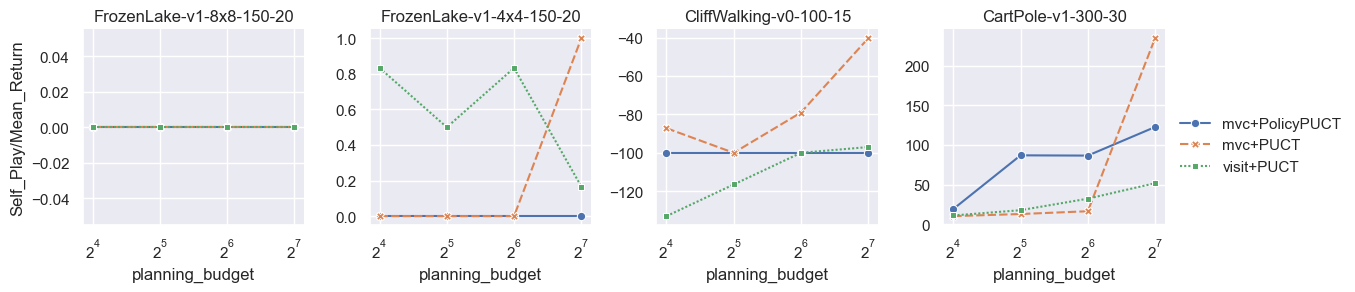

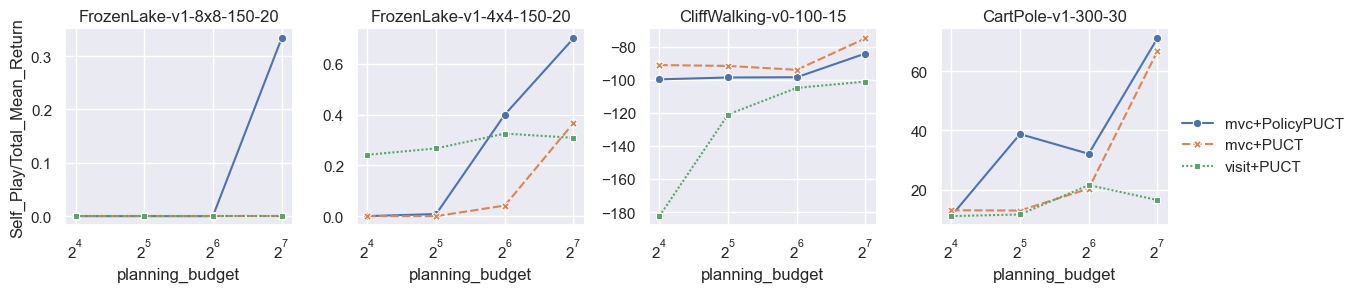

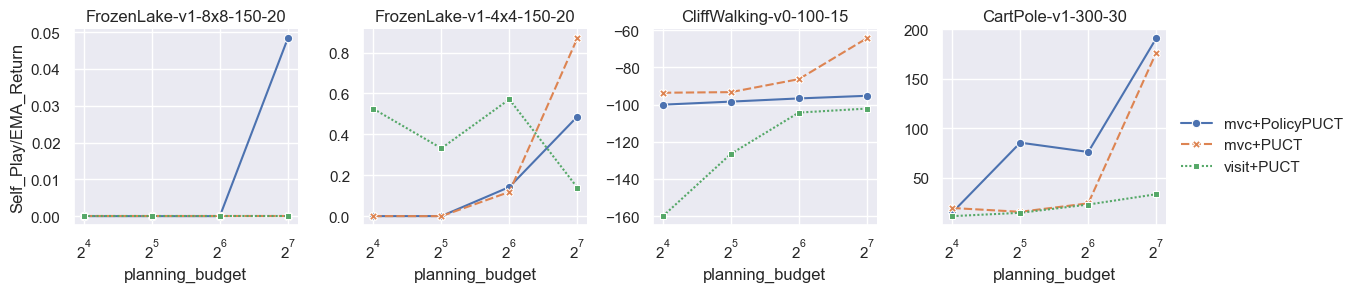

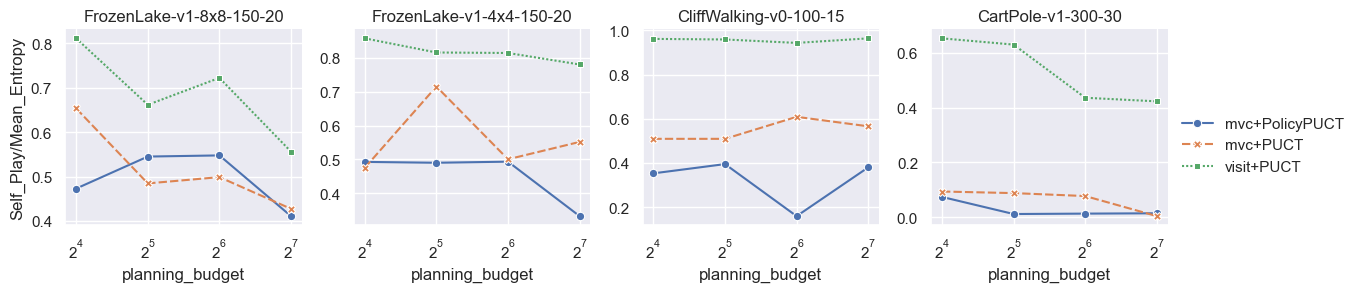

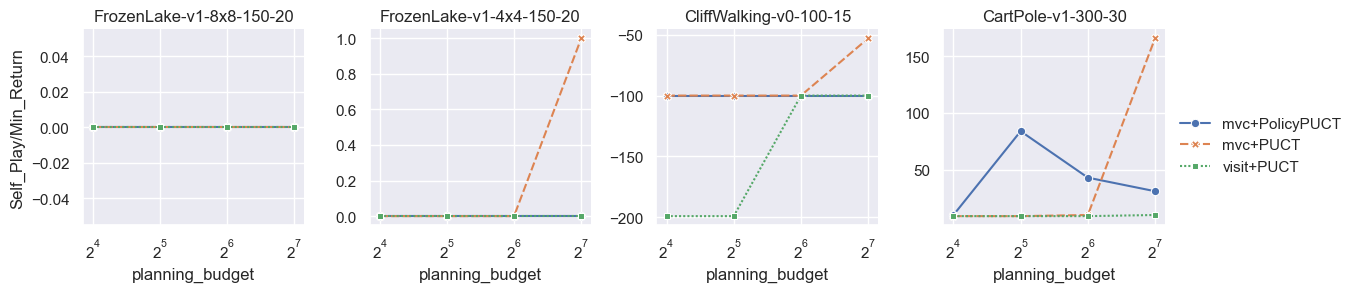

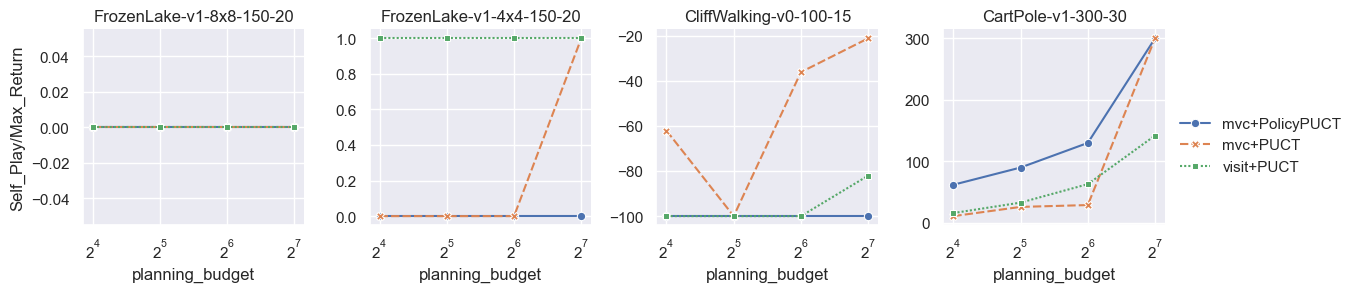

In [26]:


from email.mime import base


df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

metrics = ['Self_Play/Mean_Return', "Self_Play/Total_Mean_Return", "Self_Play/EMA_Return", 'Self_Play/Mean_Entropy', 'Self_Play/Min_Return',
           'Self_Play/Max_Return',]


estimator = "mean"
for metric in metrics:
    # Step 1: Set up the FacetGrid to create one subplot for each unique value in 'env_description'
    # Note: adjust size and aspect to fit your data and preference
    g = sns.FacetGrid(df, col="env_description",sharex=True, sharey=False)

    # Step 2: Use map_dataframe to draw the lineplots on each subplot
    # Pass sns.lineplot as the plotting function and its arguments
    g.map_dataframe(sns.lineplot,
                    x=x_metric, y=metric,
                    hue="policy_combination", style="policy_combination",
                    markers=True, errorbar="se", estimator="mean")  # adjust 'estimator' as needed

    for ax in g.axes.flatten():
        ax.set_xscale('log', base=2)

    # Step 3: Adjusting aesthetics (optional)
    # Adding a legend
    g.add_legend()

    # Set the titles for each subplot for clarity
    g.set_titles("{col_name}")

    # Adjust the labels/titles as needed
    g.set_axis_labels(x_metric, metric)

    plt.show()